In [1]:
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour

In [2]:
import rasterio
import numpy as np
import matplotlib as mpl
import subprocess
from matplotlib import pyplot as plt
from rasterio.merge import merge
import geopandas as gpd
import os, math

## Try on Cropping

In [3]:
from rasterio.crs import CRS
from rasterio.warp import transform_geom
import rasterio.mask

from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from descartes import PolygonPatch

In [4]:
raw_file = rasterio.open('MERGED/20130301/NDWI2.TIF')
eps = 3 * 1000

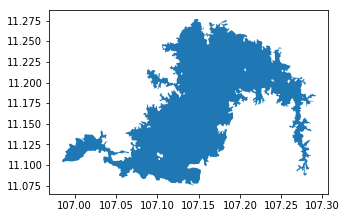

In [6]:
vn_reservoirs_path = 'vnreservoirs/VN_Reservoirs.shp'
df = gpd.read_file(vn_reservoirs_path)
plt.rcParams['figure.figsize'] = 5, 5
ho_tri_an = df[df.AREA_SKM == 277.4]

ho_tri_an.plot()
ho_tri_an_shape = ho_tri_an.geometry.values[0]
ho_tri_an_geom = mapping(ho_tri_an_shape)
ho_tri_an_shape = [transform_geom(df.crs, raw_file.crs,ho_tri_an_geom)]

In [7]:
inf = float("inf")
x0, y0, x1, y1 = [inf, -inf, -inf, inf] #top-left, bottom-right
for x, y in ho_tri_an_shape[0]['coordinates'][0]:
    if x0 > x:
        x0 = x
    if x1 < x:
        x1 = x
    if y0 < y:
        y0 = y
    if y1 > y:
        y1 = y
new_coordinates = [{'type': 'Polygon', 'coordinates': [[(x0-eps, y0+eps),(x1+eps, y0+eps), 
                                                        (x1+eps, y1-eps), (x0-eps, y1-eps)]]}]
raw_data_crop, _ = rasterio.mask.mask(raw_file, new_coordinates, crop=True)

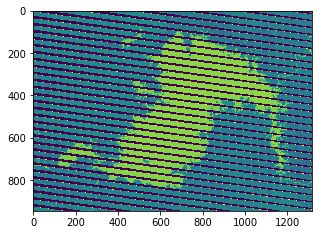

In [8]:
raw_data_crop = raw_data_crop.squeeze()
plt.imshow(raw_data_crop)

In [10]:
import gdal
from gdal import FillNodata as FillMask

In [30]:
source = gdal.Open('L7_Data/20130301/B1.TIF').GetRasterBand(1)
mask = gdal.Open('L7_Data/20130301/gap_mask/LE07_L1TP_124052_20130308_20161126_01_T1_GM_B1.TIF').GetRasterBand(1) 

In [29]:
filled_data = FillMask(source, mask, 100, 0)
type(source)

osgeo.gdal.Band

## Using Active Contour

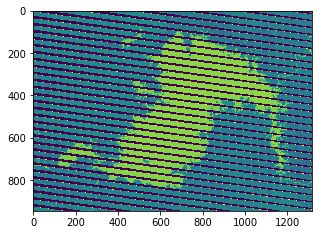

In [14]:
img = rgb2gray(raw_data_crop)
plt.imshow(img)

[0, 1317, 945, 0]

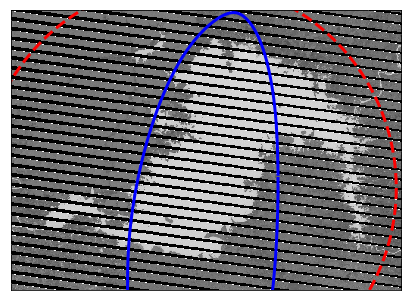

In [19]:
s = np.linspace(0, 2*np.pi, 400)
x = 600 + 700*np.cos(s)
y = 600 + 700*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

## GDAL

In [34]:
source_file = gdal.Open('L7_Data/20130301/B1.TIF')
mask_file = gdal.Open('L7_Data/20130301/gap_mask/LE07_L1TP_124052_20130308_20161126_01_T1_GM_B1.TIF')

In [48]:
source = source_file.GetRasterBand(1)
mask = mask_file.GetRasterBand(1)
FillMask(source, mask, 100, 0)

0

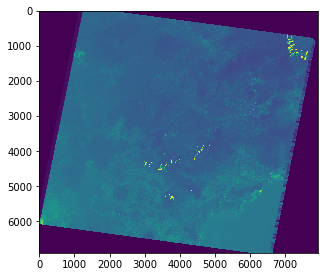

In [51]:
plt.imshow(source.ReadAsArray())

In [ ]:
outFileName = 
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!

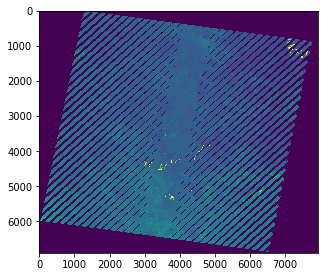

In [39]:
plt.imshow(source_file.ReadAsArray())